In [1]:
import pandas as pd

train_df = pd.read_csv("/kaggle/input/wer-prediction/wer_prediction_train.csv")
val_df   = pd.read_csv("/kaggle/input/wer-prediction/wer_prediction_val.csv")
test_df  = pd.read_csv("/kaggle/input/wer-prediction/wer_prediction_test.csv")


In [2]:
FEATURE_COLS = [
    "duration_sec",
    "word_count",
    "char_count",
    "avg_word_len",
    "speaking_rate",
    "energy",
    "zcr",
    "spectral_centroid",
    "silence_ratio",
    "snr",
]

TARGET = "wer"

X_train = train_df[FEATURE_COLS]
y_train = train_df[TARGET]

X_val = val_df[FEATURE_COLS]
y_val = val_df[TARGET]

X_test = test_df[FEATURE_COLS]
y_test = test_df[TARGET]


In [3]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

In [4]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=14,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

val_preds = rf_model.predict(X_val)

print("Random Forest (val)")
print("R² :", r2_score(y_val, val_preds))
print("MAE:", mean_absolute_error(y_val, val_preds))


Random Forest (val)
R² : -8.831043108501122
MAE: 0.5028140710755599


In [5]:
test_preds = rf_model.predict(X_test)


print("Random Forest (test)")
print("R² :", r2_score(y_test, test_preds))
print("MAE:", mean_absolute_error(y_test, test_preds))


Random Forest (test)
R² : 0.02243522885763105
MAE: 0.32101549244955513


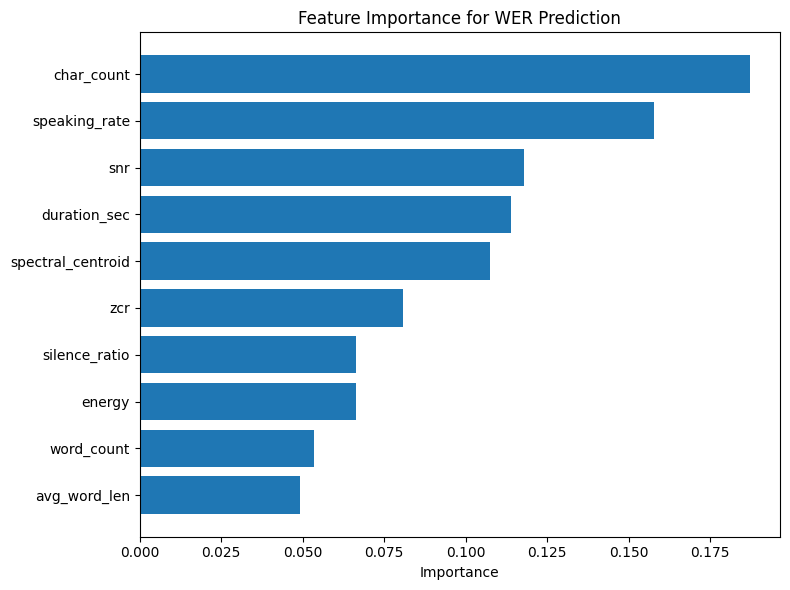

In [6]:
import matplotlib.pyplot as plt
import numpy as np

importances = rf_model.feature_importances_
idx = np.argsort(importances)

plt.figure(figsize=(8,6))
plt.barh(np.array(FEATURE_COLS)[idx], importances[idx])
plt.xlabel("Importance")
plt.title("Feature Importance for WER Prediction")
plt.tight_layout()
plt.show()


In [8]:
train_df["split"] = "train"
val_df["split"]   = "val"
test_df["split"]  = "test"

In [ ]:
df = pd.concat(
    [train_df, val_df, test_df],
    ignore_index=True
)


In [25]:
kpis = {
    "avg_wer": df["wer"].mean(),
    "median_wer": df["wer"].median(),
    "p90_wer": df["wer"].quantile(0.90),
    "high_wer_pct": (df["wer"] > 0.5).mean() * 100,

    "avg_duration": df["duration_sec"].mean(),
    "avg_words": df["word_count"].mean(),
    "avg_speaking_rate": df["speaking_rate"].mean(),
    "avg_snr": df["snr"].mean(),
}


In [26]:
FEATURES = [
    "duration_sec",
    "speaking_rate",
    "energy",
    "snr",
    "word_count",
    "avg_word_len",
    "zcr",
    "spectral_centroid",
    "silence_ratio",
]

feature_labels = {
    f: f.replace("_", " ").title() for f in FEATURES
}


In [27]:
import json

js_data = {
    "wer": df["wer"].tolist(),
    "pred_text": df["pred_text"].tolist(),
    "gt_text": df["gt_text"].tolist(),
}

for f in FEATURES:
    js_data[f] = df[f].tolist()

js_data_json = json.dumps(js_data)


In [33]:
html = f"""
<!DOCTYPE html>
<html>
<head>
    <title>ASR WER Dashboard</title>
    <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
    <style>
        body {{
            font-family: Arial, sans-serif;
            background: #f5f7fa;
            padding: 20px;
        }}
        h1 {{ text-align: center; }}

        .grid {{
            display: grid;
            grid-template-columns: repeat(4, 1fr);
            gap: 15px;
            margin-bottom: 25px;
        }}
        .grid-2 {{
            display: grid;
            grid-template-columns: 1fr 1fr;
            gap: 15px;
            margin-bottom: 25px;
        }}
        .grid-2-equal {{
            display: grid;
            grid-template-columns: 1fr 1fr;
            gap: 15px;
        }}
        .card {{
            background: white;
            border-radius: 10px;
            padding: 15px;
            box-shadow: 0 4px 10px rgba(0,0,0,0.08);
        }}
        .kpi h2 {{ margin: 0; }}
        select {{
            width: 100%;
            padding: 8px;
            font-size: 14px;
        }}
        .kpi {{
            position: relative;
            cursor: help;
        }}
        
        .kpi::after {{
            content: attr(data-tooltip);
            position: absolute;
            bottom: 110%;
            left: 50%;
            transform: translateX(-50%);
            background: #222;
            color: #fff;
            padding: 6px 10px;
            border-radius: 6px;
            font-size: 12px;
            white-space: nowrap;
            opacity: 0;
            pointer-events: none;
            transition: opacity 0.2s ease;
            z-index: 10;
        }}
        
        .kpi:hover::after {{
            opacity: 1;
        }}

    </style>
</head>

<body>

<h1>ASR WER Analysis Dashboard</h1>

<!-- KPI CARDS -->
<div class="grid" style="grid-template-columns: repeat(4, 1fr);">

    <div class="card kpi" data-tooltip="Mean word error rate across all samples">
        <h2>{kpis['avg_wer']:.3f}</h2>
        <p>Average WER</p>
    </div>

    <div class="card kpi" data-tooltip="Median WER (robust to outliers)">
        <h2>{kpis['median_wer']:.3f}</h2>
        <p>Median WER</p>
    </div>

    <div class="card kpi" data-tooltip="90th percentile WER — worst-case behavior">
        <h2>{kpis['p90_wer']:.3f}</h2>
        <p>90th %ile WER</p>
    </div>

    <div class="card kpi" data-tooltip="Percentage of utterances with WER ≥ 0.5">
        <h2>{kpis['high_wer_pct']:.1f}%</h2>
        <p>High-WER Rate</p>
    </div>

    <div class="card kpi" data-tooltip="Average audio duration in seconds">
        <h2>{kpis['avg_duration']:.2f}s</h2>
        <p>Avg Duration</p>
    </div>

    <div class="card kpi" data-tooltip="Average number of words per utterance">
        <h2>{kpis['avg_words']:.1f}</h2>
        <p>Avg Word Count</p>
    </div>

    <div class="card kpi" data-tooltip="Words spoken per second (speech tempo)">
        <h2>{kpis['avg_speaking_rate']:.2f}</h2>
        <p>Speaking Rate</p>
    </div>

    <div class="card kpi" data-tooltip="Average signal-to-noise ratio (higher is cleaner)">
        <h2>{kpis['avg_snr']:.1f}</h2>
        <p>Avg SNR</p>
    </div>

</div>

<!-- FEATURE SELECTOR -->
<div class="card" style="margin-bottom:20px;">
    <h3>Select Feature</h3>
    <select id="featureSelect" onchange="updateFeature()">
        {''.join(f"<option value='{f}'>{feature_labels[f]}</option>" for f in FEATURES)}
    </select>
</div>

<!-- MAIN VISUALS -->
<div class="grid-2">
    <div class="card">
        <h3>WER vs Feature</h3>
        <div id="scatter"></div>
    </div>
    <div class="card">
        <h3>WER Distribution</h3>
        <div id="wer_hist"></div>
    </div>
</div>

<div class="grid-2-equal">
    <div class="card">
        <h3>Feature Distribution</h3>
        <div id="feat_hist"></div>
    </div>
    <div class="card">
        <h3>Error Examples</h3>
    
        <select id="werFilter" onchange="updateExamples()">
            <option value="high">High WER (≥ 0.5)</option>
            <option value="medium">Medium WER (0.2 – 0.5)</option>
            <option value="low">Low WER (&lt; 0.2)</option>
        </select>
    
        <ul id="exampleList" style="margin-top:10px;"></ul>
    </div>
</div>

<script>
const data = {js_data_json};

function updateFeature() {{
    const feature = document.getElementById("featureSelect").value;

    Plotly.newPlot("scatter", [{{
        x: data[feature],
        y: data.wer,
        mode: "markers",
        type: "scatter",
        text: data.pred_text,
    }}], {{
        xaxis: {{ title: feature.replace(/_/g, " ") }},
        yaxis: {{ title: "WER" }},
        margin: {{ t: 30 }}
    }});

    Plotly.newPlot("feat_hist", [{{
        x: data[feature],
        type: "histogram"
    }}], {{
        xaxis: {{ title: feature.replace(/_/g, " ") }},
        margin: {{ t: 30 }}
    }});
}}

Plotly.newPlot("wer_hist", [{{
    x: data.wer,
    type: "histogram"
}}], {{
    xaxis: {{ title: "WER" }},
    margin: {{ t: 30 }}
}});

updateFeature();

function updateExamples() {{
    const mode = document.getElementById("werFilter").value;
    let filtered = [];

    if (mode === "high") {{
        filtered = data.wer
            .map((w, i) => ({{ w, i }}))
            .filter(d => d.w >= 0.5);
    }} else if (mode === "medium") {{
        filtered = data.wer
            .map((w, i) => ({{ w, i }}))
            .filter(d => d.w >= 0.2 && d.w < 0.5);
    }} else {{
        filtered = data.wer
            .map((w, i) => ({{ w, i }}))
            .filter(d => d.w < 0.2);
    }}

    filtered = filtered.slice(0, 5);

    const list = document.getElementById("exampleList");
    list.innerHTML = "";

    filtered.forEach(d => {{
        const li = document.createElement("li");
        li.innerHTML = `
            <b>WER ${{d.w.toFixed(2)}}</b><br/>
            <i>Pred:</i> ${{data.pred_text[d.i].slice(0, 80)}}...<br/>
            <i>GT:</i> ${{data.gt_text[d.i].slice(0, 80)}}...
        `;
        list.appendChild(li);
    }});
}}

updateExamples();



</script>

</body>
</html>
"""


In [34]:
with open("wer_dashboard.html", "w") as f:
    f.write(html)
